In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
import keras_cv
import math
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from tensorflow import keras
from keras import layers

2024-10-08 18:44:42.387100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 18:44:42.387242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 18:44:42.531695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ROOT = '/kaggle/input/adni-selected/ADNI SELECTED'
num_class = 2
BATCH_SIZE = 64

In [3]:
hyperparameters = {
    'learning_rate':0.001, 
    'weight_decay':0.0001, 
    'batch_size':164,
    'num_epochs':35,
    'image_size':(224,224),
    'patch_size':[4,8,16],
    'num_patches':[224 // 4, 224 // 8, 224 // 16],
    'projection_dim': 64,
    'num_heads':[4,8,16],
    'transformer_units' : [
        128,
        64
    ], # size of the transformer layers,
    'transformer_layers': 8,
    'mlp_head_units':[
        2048,
        1024
    ], # Size of the dense layers of the final classification
    'meta_step_size':0.25,
    'inner_batch_size':25,
    'eval_batch_size':25,
    'meta_iters':100,
    'eval_iters':5,
    'inner_iters':4,
    'eval_interval':1,
    'train_shots':20,
    'shots':5,
    'meta_classes':2
}

In [4]:
class Dataset():
    def __init__(self, root, batch_size=32, img_size=256, shuffle=False, KFold=False, OneHot = False):
        self.ROOT = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.KFold = KFold
        self.imgx = []
        self.labels = []
        self.img_size = img_size
        self.OneHot = OneHot
        
        for i in os.listdir(self.ROOT):
            path = os.path.join(self.ROOT,i)
            for j in os.listdir(path):
                self.imgx.append(os.path.join(path,j))
                self.labels.append(i)
                
       
        self.imgx = np.array(self.imgx)
        self.le = LabelEncoder()
        self.encoded_labels = self.le.fit_transform(self.labels)
        if self.OneHot == True:
            self.encoded_labels = tf.one_hot(self.encoded_labels,3)
        self.encoded_labels = np.array(self.encoded_labels)
        if self.OneHot == True:
            self.encoded_labels = LabelBinarizer.fit_transform(self.encoded_labels)
            print(self.encoded_labels[:5])
        if self.shuffle == True:
            indices = np.random.RandomState(42).permutation(len(self.imgx))
            self.imgx = self.imgx[indices]
            self.encoded_labels = self.encoded_labels[indices]
            
            
        
        
    def __read_and_preprocess_image__(self,image):
        img = tf.io.read_file(image)
        img = tf.io.decode_jpeg(img,channels=3)
        img = tf.cast(img,tf.float32) / 255.0
        img = tf.expand_dims(img,axis=0)
        img = tf.keras.layers.Cropping2D(cropping=((35,29),(20,20)))(img)
        img = tf.squeeze(img)
        img = tf.image.resize(img,[self.img_size,self.img_size])
        img = tf.image.per_image_standardization(img)
        return img
    
    def get_data(self):
        total = self.imgx.shape[0]
        num_loops = math.floor(self.imgx.shape[0] / self.batch_size)
        self.imgx = self.imgx[:-(total-self.batch_size*num_loops)]
        self.encoded_labels = self.encoded_labels[:-(total-self.batch_size*num_loops)]
        self.imgx = self.imgx.reshape(num_loops,self.batch_size)
        self.encoded_labels = self.encoded_labels.reshape(num_loops,self.batch_size,3)
        for batch_i,batch_l in zip(self.imgx,self.encoded_labels):
            for image,label in zip(batch_i,batch_l):
                image = self.__read_and_preprocess_image__(image)
                yield((image,label))
        
        
        

In [5]:
class ADNI():
    def __init__(self,one_hot=False):
        self.ROOT = ROOT
        self.folds = {}
        self.classes = ['CI','CN']
        self.imgx = []
        self.label = []
        self.data_dict = {0:[],1:[]}
        self.encoded_classes = []
        self.mini_dataset = []
        self.counter = 0
        self.one_hot = one_hot
        self.le = LabelEncoder()
        for i in self.classes:
            path = os.path.join(self.ROOT,i)
            for j in os.listdir(path):
                self.imgx.append(os.path.join(path,j))
                self.label.append(i)
                self.data_dict[self.counter].append(os.path.join(path,j))
            self.counter+=1
        self.imgx = np.array(self.imgx)
        self.label = np.array(self.label)
        self.encoded_labels = self.le.fit_transform(self.label)
        if self.one_hot == True:
            self.encoded_labels = LabelBinarizer().fit_transform(self.encoded_labels)
            print(self.encoded_labels[:5])
        self.dataset = self.get_dataset(KFold=True)


       
        
    def __give_K_folds__(self,k):
        folds = {new_list:{'train':{'imgx':[],'label':[]},'test':{'imgx':[],'label':[]}} for new_list in range(k)}
        self.folds = folds
        kf = KFold(n_splits=k,shuffle=True,random_state=42)
        for i, (train_index, test_index) in enumerate(kf.split(self.imgx,self.encoded_labels)):
            self.folds[i]['train']['imgx'].append(self.imgx[train_index])
            self.folds[i]['train']['label'].append(self.encoded_labels[train_index])
            self.folds[i]['test']['imgx'].append(self.imgx[test_index])
            self.folds[i]['test']['label'].append(self.encoded_labels[test_index])  
        return self.folds
    
    
    def __load_and_normalize_image__(self,image,label):
        img = tf.io.read_file(image)
        img = tf.io.decode_jpeg(img,channels=3)
        img = tf.image.resize(img,(256,256))
        img = tf.expand_dims(img,axis=0)
        img = tf.keras.layers.Cropping2D(cropping=((35,29),(20,20)))(img)
        img = tf.squeeze(img)
        img = tf.image.resize(img,(256,256))
        img = tf.cast(img,tf.float32)/255.
#         img = tf.image.per_image_standardization(img)
        
        return img, label
    
    def __load_and_normalize_image2__(self,image):
        img = tf.io.read_file(image)
        img = tf.io.decode_jpeg(img,channels=3)
        img = tf.image.resize(img,(224,224))
        img = tf.cast(img,tf.float32) / 255.0
        return img
    
    def get_dataset(self,val_split=0.2,Shuffle=False,KFold=False,K=5,BATCH_SIZE=32):
        if KFold == False:
            train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(self.ROOT,batch_size=BATCH_SIZE,image_size=(256,256),shuffle=Shuffle, seed=42, validation_split=val_split,subset='both')
            return {'train':train_ds, 'validation':validation_ds}
        else:
            dataset = {new_list:{'train':[],'validation':[]} for new_list in range(K)}
            folds = self.__give_K_folds__(K)
            for fold in folds.keys():
                train_dataset = tf.data.Dataset.from_tensor_slices((folds[fold]['train']['imgx'][0],folds[fold]['train']['label'][0]))
                train_dataset = train_dataset.map(self.__load_and_normalize_image__,tf.data.AUTOTUNE)
                test_dataset = tf.data.Dataset.from_tensor_slices((folds[fold]['test']['imgx'][0],folds[fold]['test']['label'][0]))
                test_dataset = test_dataset.map(self.__load_and_normalize_image__,tf.data.AUTOTUNE)
                dataset[fold]['train']=train_dataset
                dataset[fold]['validation'] = test_dataset
            self.dataset =  dataset
            return dataset


    def __give_K_folds__(self, k):
        # Function to split the dataset into K folds
        self.folds = {fold_idx: {'train': {'imgx': [], 'label': []}, 'test': {'imgx': [], 'label': []}} for fold_idx in range(k)}
        
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        for fold_idx, (train_index, test_index) in enumerate(kf.split(self.imgx, self.encoded_labels)):
            self.folds[fold_idx]['train']['imgx'].append(self.imgx[train_index])
            self.folds[fold_idx]['train']['label'].append(self.encoded_labels[train_index])
            self.folds[fold_idx]['test']['imgx'].append(self.imgx[test_index])
            self.folds[fold_idx]['test']['label'].append(self.encoded_labels[test_index])
        
        return self.folds

    def __load_and_normalize_image__(self, img_path, label):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        img = img / 255.0  # Normalize to [0, 1]
        return img, label
    
    
        
    def get_mini_dataset(self,fold,batch_size=32,repetitions=3, shots=5, num_classes=2, split=False):
        sub_indices = random.sample(range(len(self.encoded_classes)),k=num_classes)
        print(sub_indices)
        label_subset = np.array(self.encoded_classes)[sub_indices]
        meta_labels = np.zeros(num_classes*shots)
        meta_test_labels = np.zeros(num_classes)
        meta_img_paths = []
        meta_test_img_paths = []
        for class_idx, class_obj in enumerate(label_subset):
            meta_labels[class_idx*shots:(class_idx+1)*shots]=class_idx
            img_paths = random.sample(range(len(self.data_dict[class_obj])),k=shots+1)
            for i in img_paths:
                meta_img_paths.append(self.data_dict[class_obj][i])
            meta_test_img_paths.append(meta_img_paths[-1])
            meta_img_paths = meta_img_paths[:-1]
        meta_test_img_paths = np.array(meta_test_img_paths)
        meta_img_paths = np.array(meta_img_paths)
        test_images = []
        for i,j in zip(meta_test_img_paths,meta_test_labels):
            test_images.append(self.__load_and_normalize_image2__(i))
            
        train_dataset = tf.data.Dataset.from_tensor_slices((meta_img_paths,meta_labels))
        train_dataset = train_dataset.map(self.__load_and_normalize_image__,tf.data.AUTOTUNE)
        train = train_dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        return train, test_images, meta_test_labels

In [6]:
dataset = ADNI().get_dataset(KFold=True)

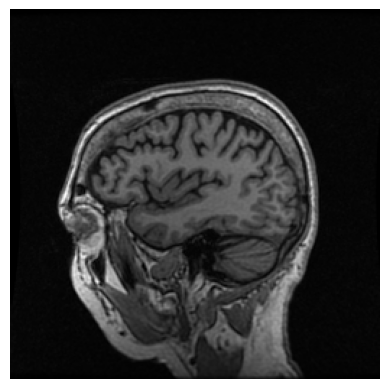

tf.Tensor(0, shape=(), dtype=int64)


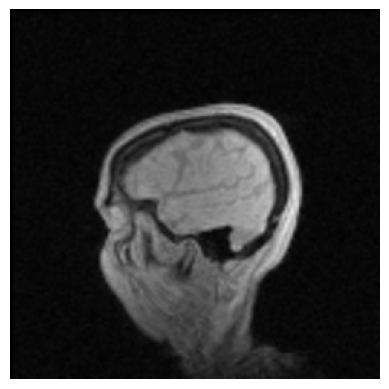

tf.Tensor(0, shape=(), dtype=int64)


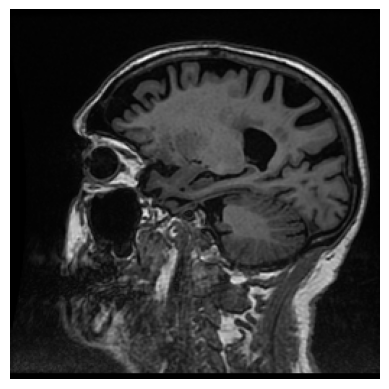

tf.Tensor(0, shape=(), dtype=int64)


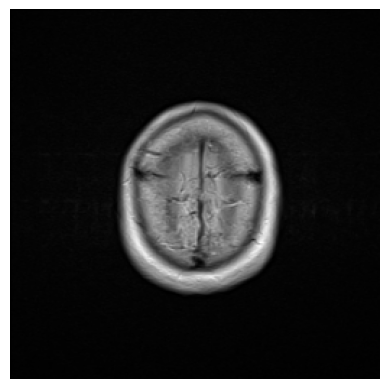

tf.Tensor(0, shape=(), dtype=int64)


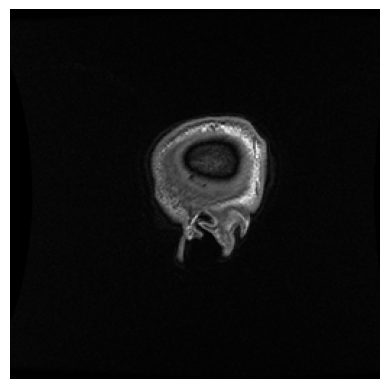

tf.Tensor(0, shape=(), dtype=int64)


In [7]:
def show_sample_images(num_samples=5,train=True,axis='off'):
    for counter, (i,j) in zip(range(num_samples),dataset[0]['train'].shuffle(6000)):
        plt.imshow(i)
        plt.axis(axis)
        plt.show()
        print(j)
show_sample_images()

# TIME FOR MOBILE VIT
* ### <a href = 'https://keras.io/examples/vision/mobilevit/'>Keras Code Here</a>

In [8]:
patch_size = 4
image_size = 256
expansion_factor = 2


In [9]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=tf.keras.activations.swish,
        padding='same'
    )
    
    return conv_layer(x)

def correct_pad(inputs,kernel_size):
    img_dim = 2 if tf.keras.backend.image_data_format()=='channels_first' else 1
    input_size = inputs.shape[img_dim:(img_dim+2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
        
    if input_size[0] is None:
        adjust = (1,1)
    else:
        adjust = (1-input_size[0]%2,1-input_size[1]%2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0]-adjust[0], correct[0]),
        (correct[1]-adjust[1], correct[1])
    )

def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = tf.keras.layers.Conv2D(expanded_channels, 1, padding='same', use_bias=False)(x)
    m = tf.keras.layers.BatchNormalization()(m)
    m = tf.keras.activations.swish(m)
    
    if strides == 2:
        m = tf.keras.layers.ZeroPadding2D(padding=correct_pad(m,3))(m)
    m = tf.keras.layers.DepthwiseConv2D(3, strides=strides,padding='same' if strides==1 else 'valid', use_bias=False)(m)
    m = tf.keras.layers.BatchNormalization()(m)
    m = tf.keras.activations.swish(m)
    m = tf.keras.layers.Conv2D(output_channels, 1, padding='same', use_bias = False)(m)
    m = tf.keras.layers.BatchNormalization()(m)
    
    if tf.keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return tf.keras.layers.Add()([m,x])
    return m


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, x])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3,hidden_units=[x.shape[-1]*2,x.shape[-1]],dropout_rate=0.1)
        x = tf.keras.layers.Add()([x3,x2])
    return x

def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(local_features, filters=projection_dim,kernel_size=1,strides=strides)
    num_patches = int((local_features.shape[1]*local_features.shape[2])/patch_size)
    non_overlapping_patches = tf.keras.layers.Reshape((patch_size,num_patches,projection_dim))(local_features)
    global_features = transformer_block(non_overlapping_patches, num_blocks, projection_dim)
    
    folded_feature_map = tf.keras.layers.Reshape((*local_features.shape[1:-1], projection_dim))(global_features)
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = tf.keras.layers.Concatenate(axis=-1)([x, folded_feature_map])
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )
    return local_global_features
    
        

In [ ]:
def create_mobilevit(num_classes=3):
    inputs = tf.keras.Input((image_size, image_size, 3))
    x = inputs

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

    return tf.keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

In [ ]:
# ad_samples = len(os.listdir(os.path.join(ROOT,'AD')))
ci_samples = len(os.listdir(os.path.join(ROOT,'CI')))
cn_samples = len(os.listdir(os.path.join(ROOT,'CN')))
total =  ci_samples + cn_samples
print( ci_samples, cn_samples,total)

In [ ]:
# ad_weights = (1/ad_samples)*(total/2.0)
ci_weights = (1/ci_samples)*(total/2.0)
cn_weights = (1/cn_samples)*(total/2.0)
print(f'class weights for  CI: {ci_weights} and CN: {cn_weights}')
class_weights = {0: ci_weights, 1: cn_weights}

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/kaggle/working/checkpoint.weights.h5',
    monitor ='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weights_only = True
)

In [ ]:
def run_experiment_with_class_weights(model,train_data,test_data):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay']
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )
    
    history = model.fit(
        x=train_data,
        batch_size=hyperparameters['batch_size'],
        epochs=hyperparameters['num_epochs'],
        validation_data=test_data,
        class_weight = class_weights,
        callbacks=model_checkpoint_callback
    )
        
    
    return history

In [ ]:
history = []
for fold in [0,1,2,3,4]:
    train_ds = dataset[fold]['train'].shuffle(6000).batch(hyperparameters['batch_size'])
    test_ds = dataset[fold]['validation'].shuffle(1500).batch(hyperparameters['batch_size'])
    print(f'<---------------- FOLD {fold} ------------------------------->')
    vit_classifier = create_mobilevit()

    h = run_experiment_with_class_weights(vit_classifier,train_ds,test_ds)
    df = pd.DataFrame.from_dict(h.history)
    df.to_csv('/kaggle/working/mViT'+str(fold)+'.csv')
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Progress')
    plt.legend(['Training','Validation'])
    plt.show()
    history.append(h)
    y_pred = []
    y_true = []
    prediction_model = create_mobilevit()
    prediction_model.load_weights('/kaggle/working/checkpoint.weights.h5')
    for image, label in dataset[fold]['validation'].batch(1):
        y_pred.append(prediction_model(image))
        y_true.append(label.numpy())
    y_pred_max = []
    for i in y_pred:
        y_pred_max.append(np.argmax(i))
        
    cm_matrix = metrics.confusion_matrix(y_true,y_pred_max)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_matrix,display_labels=['CI','CN'])
    cm_display.plot()
    plt.title('Fold '+str(fold))
    plt.savefig('/kaggle/working/confusion_matrix'+str(fold)+'.jpg')
    plt.show()
    evaluation_dict = metrics.classification_report(y_true,y_pred_max,target_names=['CI','CN'],output_dict=True)
    df2 = pd.DataFrame.from_dict(evaluation_dict)
    df2.to_csv('/kaggle/working/eval'+str(fold)+'.csv')

        

## CONV MIXER MODEL

In [7]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])


In [8]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=4, num_classes=1
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

In [9]:
with strategy.scope():
    model = get_conv_mixer_256_8(256)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │     12,544 │ rescaling[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │      1,024 │ activation[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 64, 64,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ depthwise_conv2d… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ activation_1[0][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     65,792 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ activation_2[0][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 64, 64,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ depthwise_conv2d… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ activation_3[0][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     65,792 │ add_1[0][0]     

 Total params: 609,793 (2.33 MB)

 Trainable params: 601,089 (2.29 MB)

 Non-trainable params: 8,704 (34.00 KB)

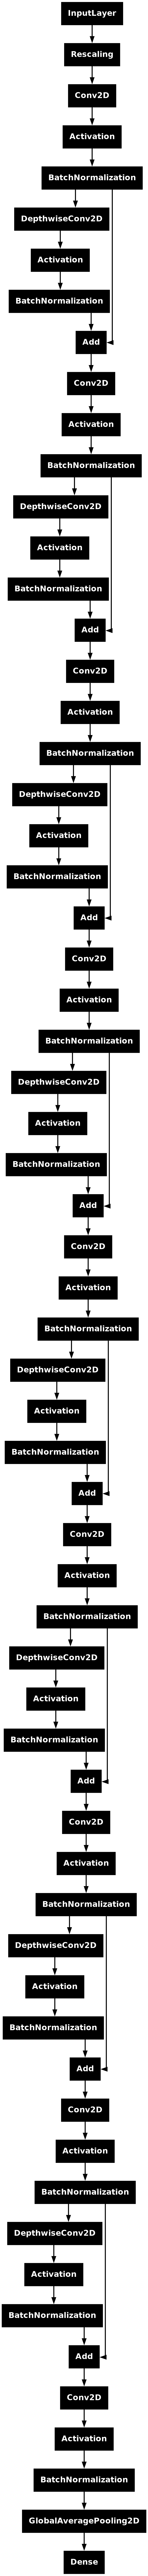

In [11]:
tf.keras.utils.plot_model(model)

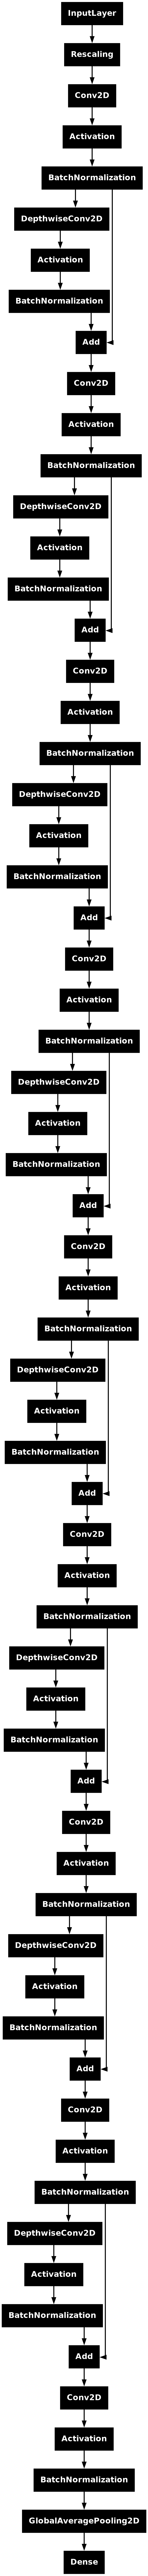

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
# ad_samples = len(os.listdir(os.path.join(ROOT,'AD')))
ci_samples = len(os.listdir(os.path.join(ROOT,'CI')))
cn_samples = len(os.listdir(os.path.join(ROOT,'CN')))
total =  ci_samples + cn_samples
print( ci_samples, cn_samples,total)

45351 32096 77447


In [14]:
# ad_weights = (1/ad_samples)*(total/2.0)
ci_weights = (1/ci_samples)*(total/2.0)
cn_weights = (1/cn_samples)*(total/2.0)
print(f'class weights for CI: {ci_weights} and CN: {cn_weights}')
class_weights = {0: ci_weights, 1: cn_weights}

class weights for CI: 0.8538620978589226 and CN: 1.2064899052841476


In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/kaggle/working/checkpoint.weights.h5',
    monitor ='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weights_only = True
)

In [16]:
def run_experiment_with_class_weights(model, train_data, test_data):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay']
    )
    
    
 
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Use the class, not the function
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    
    history = model.fit(
        x=train_data,
        batch_size=hyperparameters['batch_size'],
        epochs=hyperparameters['num_epochs'],
        validation_data=test_data,
        class_weight = class_weights,
        callbacks=model_checkpoint_callback
    )
        
    
    return history

In [17]:
history = []
for fold in [0,1,2,3,4]:
    train_ds = dataset[fold]['train'].shuffle(6000).batch(hyperparameters['batch_size'])
    test_ds = dataset[fold]['validation'].shuffle(1500).batch(hyperparameters['batch_size'])
    print(f'<---------------- FOLD {fold} ------------------------------->')
    vit_classifier = get_conv_mixer_256_8(256)

    h = run_experiment_with_class_weights(vit_classifier,train_ds,test_ds)
    df = pd.DataFrame.from_dict(h.history)
    df.to_csv('/kaggle/working/convMixer'+str(fold)+'.csv')
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Progress')
    plt.legend(['Training','Validation'])
    plt.show()
    history.append(h)
    y_pred = []
    y_true = []
    prediction_model = get_conv_mixer_256_8(256)
    prediction_model.load_weights('/kaggle/working/checkpoint.weights.h5')
    for image, label in dataset[fold]['validation'].batch(1):
        y_pred.append(prediction_model(image))
        y_true.append(label.numpy())
    y_pred_max = []
    for i in y_pred:
        y_pred_max.append(np.argmax(i))
        
    cm_matrix = metrics.confusion_matrix(y_true,y_pred_max)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_matrix,display_labels=['CI','CN'])
    cm_display.plot()
    plt.title('Fold '+str(fold))
    plt.savefig('/kaggle/working/confusion_matrix'+str(fold)+'.jpg')
    plt.show()
    evaluation_dict = metrics.classification_report(y_true,y_pred_max,target_names=['CI','CN'],output_dict=True)
    df2 = pd.DataFrame.from_dict(evaluation_dict)
    df2.to_csv('/kaggle/working/eval'+str(fold)+'.csv')

<---------------- FOLD 0 ------------------------------->
Epoch 1/35


2024-10-08 18:46:48.864329: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[128,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,64,64]{3,2,1,0}, f32[256,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=256, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-08 18:46:49.546483: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.682269137s
Trying algorithm eng3{k11=2} for conv (f32[128,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,64,64]{3,2,1,0}, f32[256,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=256, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a wh

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/2434040408.py", line 8, in <module>

  File "/tmp/ipykernel_34/1569757692.py", line 18, in run_experiment_with_class_weights

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 18792912192 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  102.91MiB
              constant allocation:        32B
        maybe_live_out allocation:    6.91MiB
     preallocated temp allocation:   17.50GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:   17.60GiB
              total fragmentation:    1.94MiB (0.01%)
Peak buffers:
	Buffer 1:
		Size: 512.00MiB
		Operator: op_type="DepthwiseConv2dNative" op_name="functional_1_1/depthwise_conv2d_11_1/depthwise" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 2:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/batch_normalization_23_1/batchnorm/add_1" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.369"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 3:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1_1/conv2d_12_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 4:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/add_10_1/Add" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.359"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 5:
		Size: 512.00MiB
		Operator: op_type="DepthwiseConv2dNative" op_name="functional_1_1/depthwise_conv2d_10_1/depthwise" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 6:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/batch_normalization_21_1/batchnorm/add_1" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.369"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 7:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1_1/conv2d_11_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 8:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/add_9_1/Add" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.359"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 9:
		Size: 512.00MiB
		Operator: op_type="DepthwiseConv2dNative" op_name="functional_1_1/depthwise_conv2d_9_1/depthwise" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 10:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/batch_normalization_19_1/batchnorm/add_1" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.369"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 11:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1_1/conv2d_10_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 12:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/add_8_1/Add" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.359"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 13:
		Size: 512.00MiB
		Operator: op_type="DepthwiseConv2dNative" op_name="functional_1_1/depthwise_conv2d_8_1/depthwise" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================

	Buffer 14:
		Size: 512.00MiB
		Operator: op_type="AddV2" op_name="functional_1_1/batch_normalization_17_1/batchnorm/add_1" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.369"
		XLA Label: fusion
		Shape: f32[128,256,64,64]
		==========================

	Buffer 15:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1_1/conv2d_9_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[128,256,64,64]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_17646]

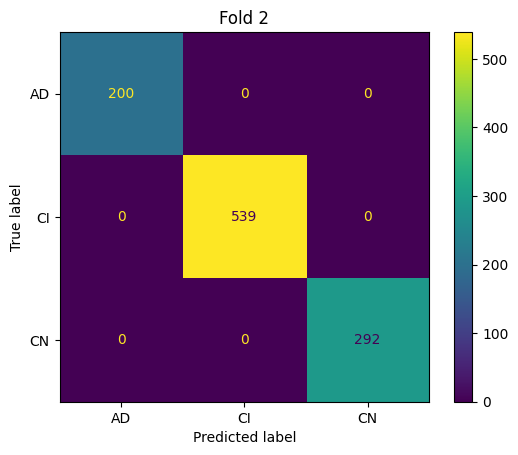

In [42]:
y_pred = []
y_true = []
prediction_model = get_conv_mixer_256_8(256)
prediction_model.load_weights('/kaggle/working/checkpoint.weights.h5')
for image, label in dataset[fold]['validation'].batch(1):
    y_pred.append(prediction_model(image))
    y_true.append(label.numpy())
y_pred_max = []
for i in y_pred:
    y_pred_max.append(np.argmax(i))

cm_matrix = metrics.confusion_matrix(y_true,y_pred_max)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_matrix,display_labels=['CI','CN'])
cm_display.plot()
plt.title('Fold '+str(fold))
plt.savefig('/kaggle/working/confusion_matrix'+str(fold)+'.jpg')
plt.show()
evaluation_dict = metrics.classification_report(y_true,y_pred_max,target_names=['CI','CN'],output_dict=True)
df2 = pd.DataFrame.from_dict(evaluation_dict)
df2.to_csv('/kaggle/working/eval'+str(fold)+'.csv')

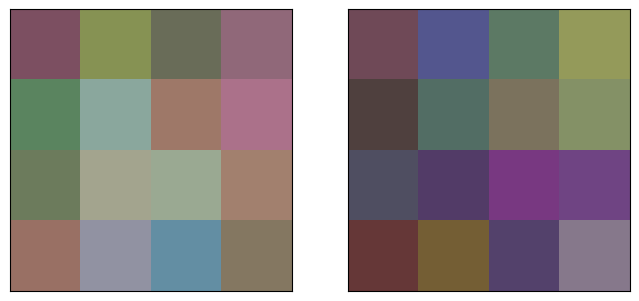

In [21]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 2
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(1, 2, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1
    plt.savefig('/kaggle/working/patch_embeddings.jpg')


# We first visualize the learned patch embeddings.
patch_embeddings = prediction_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)


5 <DepthwiseConv2D name=depthwise_conv2d_16, built=True>
12 <DepthwiseConv2D name=depthwise_conv2d_17, built=True>
19 <DepthwiseConv2D name=depthwise_conv2d_18, built=True>
26 <DepthwiseConv2D name=depthwise_conv2d_19, built=True>
33 <DepthwiseConv2D name=depthwise_conv2d_20, built=True>
40 <DepthwiseConv2D name=depthwise_conv2d_21, built=True>
47 <DepthwiseConv2D name=depthwise_conv2d_22, built=True>
54 <DepthwiseConv2D name=depthwise_conv2d_23, built=True>


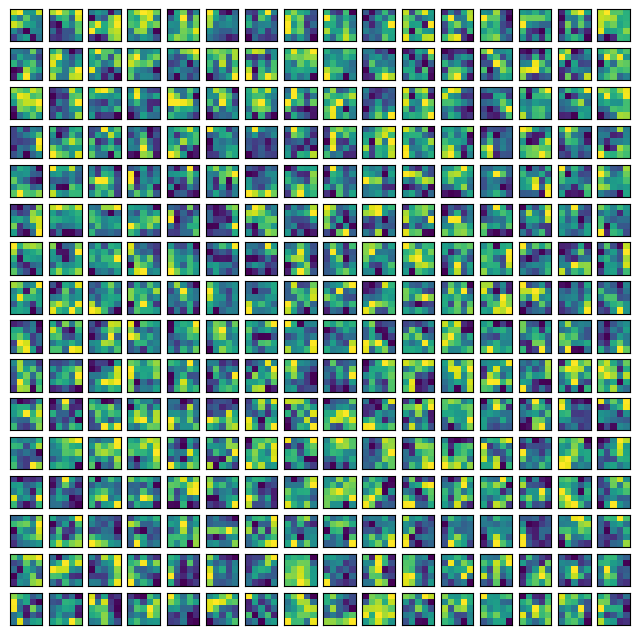

In [22]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1
    plt.savefig('/kaggle/working/raw_kernel.jpg')
for i, layer in enumerate(prediction_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = prediction_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

In [23]:
patch_size = 4


def get_cls_attention_map(
    attention_scores,
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attention_scores: the attention scores from the attention block to
            visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = ops.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        interpolation="bicubic",
    )

    return attentions

In [ ]:
attentions_ca_block_0 = get_conv_mixer_


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()